# Using SAS DLPy to Build a U-Net Semantic Segmentation Model

Deep learning semantic image segmentation models seek to understand images at the pixel level. Specifically, a semantic segmentation task attempts to partition an image into semantically meaningful parts, and classifying each part as one of a pre-determined number of classes. In other words, the model seeks to assign each pixel in the image to an object class.

This example notebook uses SAS DLPy to create a U-Net semantic segmentation model. U-Net models evolved from traditional CNN detection models. They are named for their classic U-shaped model architecture, where the left side of the "U" is a general convolutional contracting path, and the right side of the "U" is a 2D transposed convolutional expansive path. Since U-Net models localize and distinguish borders by performing classification on a pixel-by-pixel basis, the input and output images are the same size. 

This example extracts and loads raw and annotated image data from a downloaded .sashdat file into a SAS CAS table. The model data is visualized and partitioned. Using DLPy, a U-Net semantic segmentation model is defined, created, and trained. Then the U-Net model scores the test and validation data and displays an output matrix that compares raw, ground truth, and scored segmentation images.  

For more detailed information on U-Net models, see [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Ronneberger, Fischer, and Brox.

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the Semantic Segmentation Source Data](#downloadData) 
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Connect to SAS CAS](#connectCAS)
- [Create a SAS CASlib and Load the Model Data](#genData)
- [Visualize the Input Images and Annotations](#visualizeImages)
- [Split the Model Data into Training, Validation, and Test Partitions](#partition)
- [Use SAS DLPy to Define and Create a U-Net Model](#defineModel)
- [Train the U-Net Segmentation Model](#trainModel)
- [Use the U-Net Model to Score Test Data](#scoreData)
- [Compile and Display the U-Net Image Segmentation Model Predictions](#compileDisplay)

<a id="ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you might need to copy or transfer files between client and server during this example.

This step establishes server-side paths for model files and the model input image data. 

In [1]:
# This code defines variables that contain server-side 
# path specifications to the model files and source data 
# used in this image segmentation model example. 

# Server-side path to model files
model_path = r'/your-system/path-to/segmentation-files

# Server-side path to source image data in .sashdat format
image_path = r'/your-system/path-to/segmentation-files

# It is OK for model_path and image_path to share a folder

<a id="getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

This section organizes the resources that you will need and configures your computing environment for the notebook example. Performing these tasks in advance means you can run the example without stopping to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the analytic modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Semantic Segmentation Source Data

This example notebook uses a SAS-generated data set for the image segmentation analysis task. The source data contains (85 images + 85 flipped images = 170 images) that are 256 pixels x 256 pixels in size. Each observation contains a raw image as well as an annotated (ground truth) segmented image.

Download the archived SAS model data [image_semantic_segmentation_UNet_data](https://support.sas.com/documentation/prod-p/vdmml/zip/Semantic_segmentation_UNet_256.zip) (~19MB) from the [SAS Viya Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) support page. 

From the archive, extract the input data file `sgf_256.sashdat` and save it to the server location that you specified previously for the variable `image_path`.

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input data to your server, configure your client computing environment for the analytic task. 

Import the various Python utilities and SAS DLPy modules that this notebook uses. 

The SAS Scripting Wrapper for Analytic Transfer (SWAT) is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

In [2]:
# Import SAS SWAT and SWAT libraries
from swat import *

# Import sys module for OS commands
import sys

# Import required SAS DLPy modules
import dlpy 
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

# Import matplotlib graphic utilities
from matplotlib import pylab as plt
from matplotlib import image as mpimg

# Display matplotlib output in notebook cells
%matplotlib inline

<a id="connectCAS"></a>
    
### Connect to SAS CAS
After configuring your environment and loading the required libraries and functions, connect to your SAS CAS server and specify your CAS portID. SAS notebook examples use port 5570 by default, but you can substitute another port number of your own choosing.

In [3]:
# Connect to the SAS CAS Server

s=CAS('your-server.unx.company.com', 5570)

In [4]:
# Load Required SAS CAS Action Sets
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0028s, user: 0.000839s, sys: 0.00194s, mem: 0.221mb

<a id="genData"></a>

### Create a SAS Caslib and Load the Model Data 

This example notebook uses SAS-generated 256 x 256 BGR soccer images as the source data for the semantic segmentation model. Each observation in the source data contains a raw image file and a corresponding annotated (ground truth) segmentation file. 

The following code creates a SAS caslib named `soccer_images` for this analytic task.

In [5]:
# Create a SAS CASlib named `soccer_images` 
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='soccer_images',
                  path=image_path,
                  subdirectories=True)

NOTE: Cloud Analytic Services added the caslib 'soccer_images'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,soccer_images,PATH,,/your-system/path-to/segmentation/,,1.0,1.0,0.0,0.0,0.0,0.0


In the new caslib `soccer_images`, use `loadTable()` to add a CAS table named `data`, and populate the output table `data` with the contents of the SAS source file `sgf_256.sashdat`. 

In [6]:
# Create CAS table `data` and load the source 
# data from `sgf_256.sashdat` into `data`
s.table.loadTable(caslib = 'soccer_images', 
                  path='sgf_256.sashdat',
                  casout = dict(name = 'data', 
                                replace = True)
                 )

NOTE: Cloud Analytic Services made the file sgf_256.sashdat available as table DATA in caslib CASUSER(userID).


[caslib]

 'CASUSER(userID)'

[tableName]

 'DATA'

[casTable]

 CASTable('DATA', caslib='CASUSER(userID)')

+ Elapsed: 0.00155s, sys: 0.00094s, mem: 0.711mb

<a id="visualizeImages"></a>

### Visualize the Input Images and Annotations

The source data that was loaded into CAS table `data` contains both raw images and annotated (ground truth) image segmentations. Use the `display_segmentation()` function to visualize four raw input images and their corresponding ground truth segmentation.  

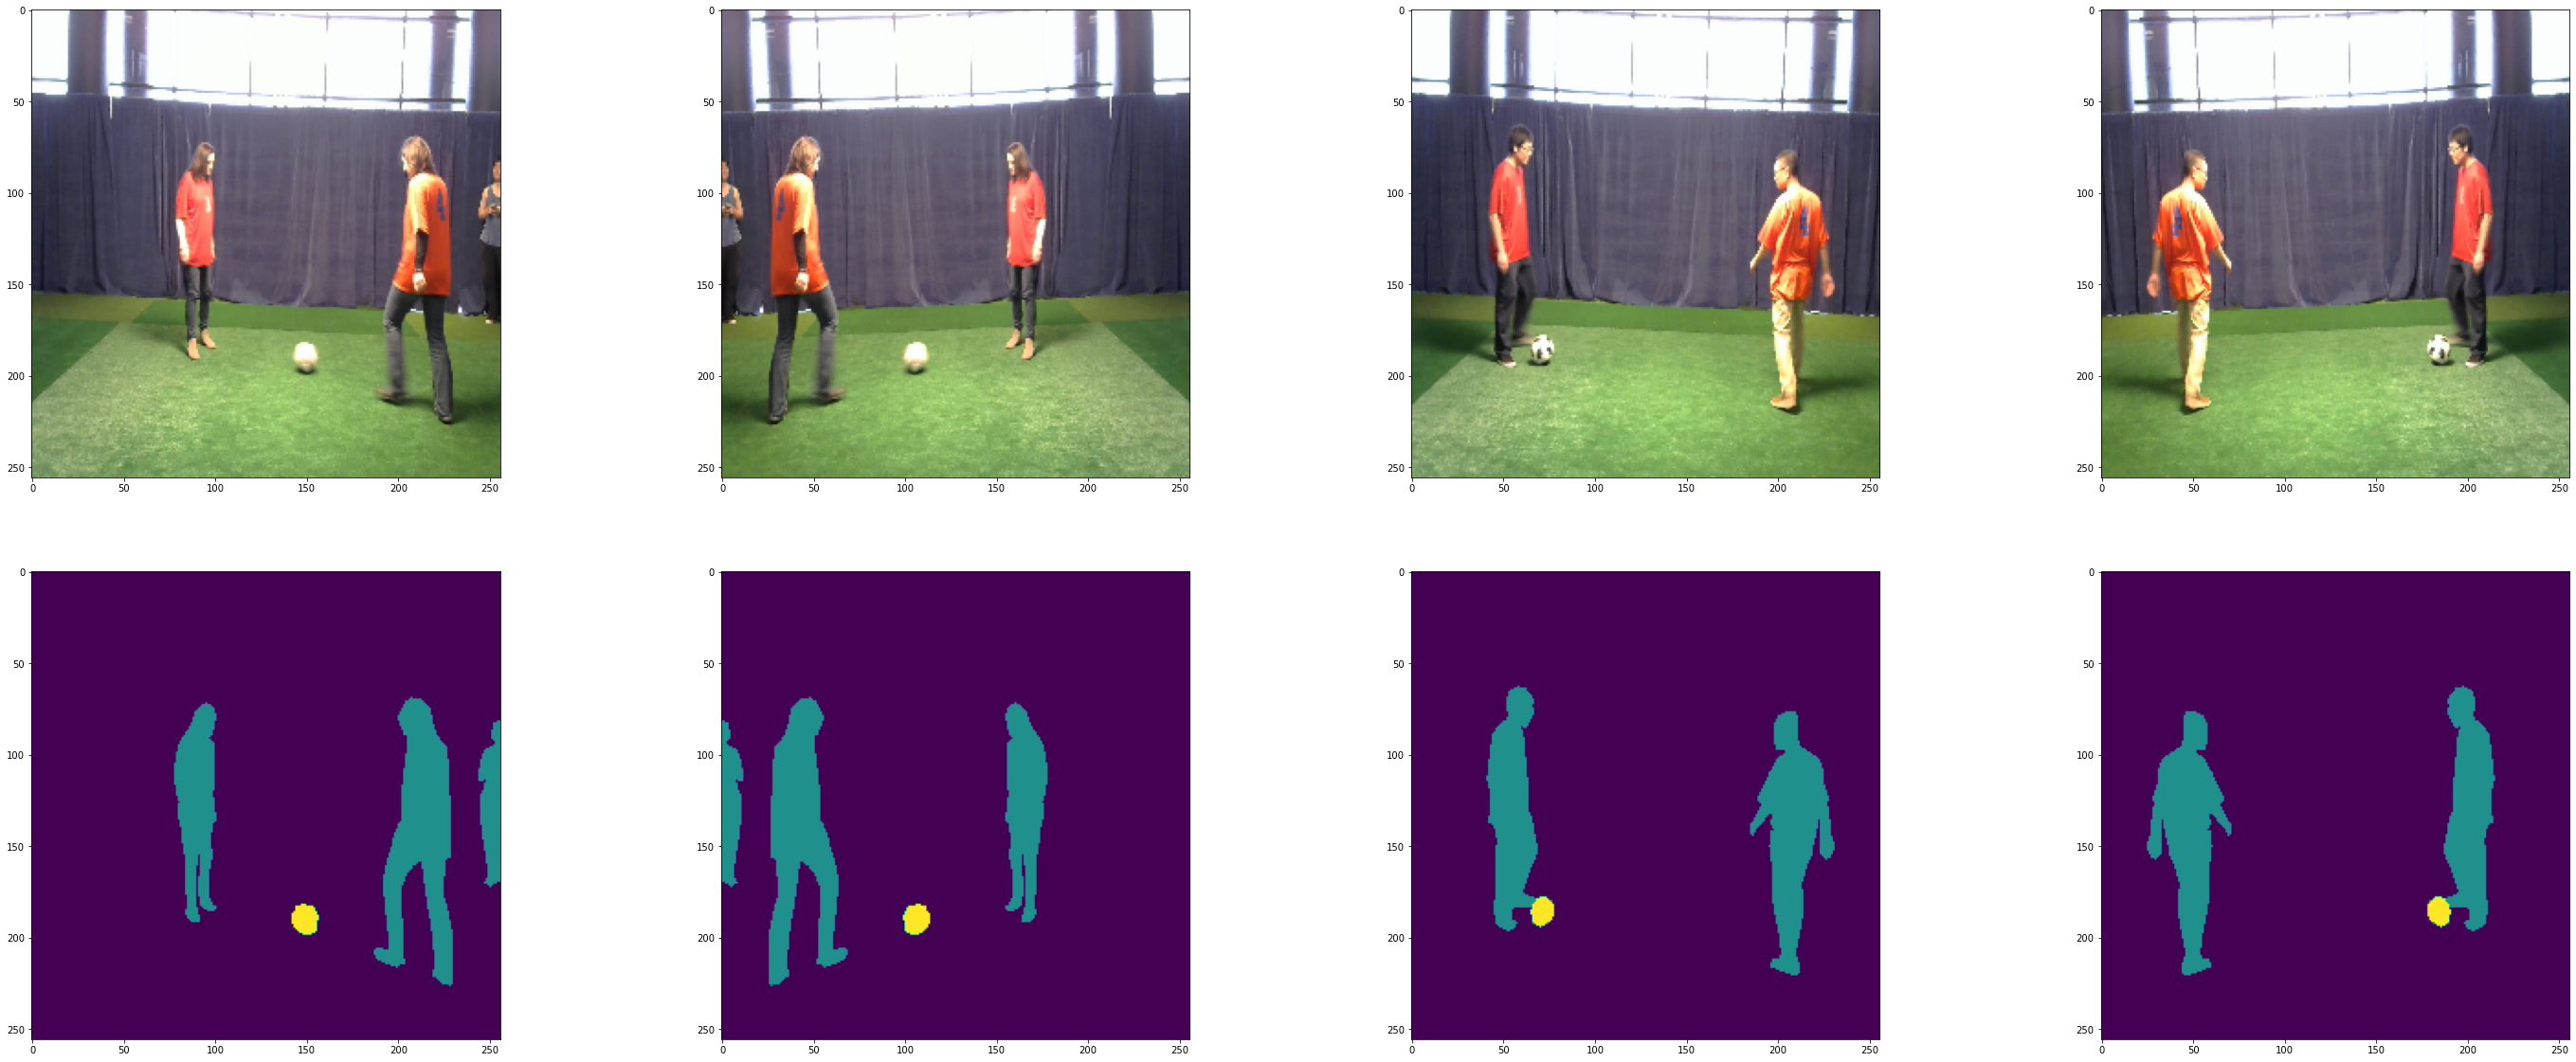

In [7]:
# Display 4 raw images and the 
# corresponding segment annotations
# from table `data`
display_segmentation_images(s, 
                            'data', 
                            n_images=4, 
                            segmentation_labels_table='data')

<a id="partition"></a>

### Split the Model Data into Training, Validation, and Test Partitions

After viewing a sample of the model images and annotations, divide the source data into training (70%), validation (20%), and test (10%) partitions:

In [8]:
# Create 70% Train partition 
train = s.CASTable('data', where = 'idx >= 0.3')

# Show number of observations in table Train
len(train)

115

The train partition contains 115 observations, or 68% of the source data. 

In [9]:
# Create the 20% Validation partition 
valid = s.CASTable('data', where = 'idx < 0.3 and idx >= 0.1')

# Show number of observations in table Train
len(valid)

33

The validation partition contains 33 observations, or 19% of the source data.  

In [10]:
# Create the 10% Test partition
test = s.CASTable('data', where = 'idx < 0.1')

# Show number of observations in table Test
len(test)

22

The test partition contains 22 observations, or 13% of the source data. The train, validation, and test partitions are fine for this analytic task.

<a id="defineModel"></a>

### Use SAS DLPy to Define and Create a U-Net Model

Instead of specifying the entire U-Net model architecture layer by layer, you can use SAS DLPy to specify only three U-Net architecture parameters to create a new U-Net model. 

Below, a UNet model named `model` is created using the DLPy `UNet()` function. The function requires only parameter values for:

<ul><li>the number of classes</li>
    <li>the number of channels</li>
    <li>whether to perform batch normalization after convolutions.</ul>
    

In [11]:
# Create U-Net Model 'model' using SAS DLPy
model = UNet(s, 
             n_classes=3, 
             n_channels=3, 
             bn_after_convolutions=True)

NOTE: Model compiled successfully.


Use `print_summary()` to display a tabular summary of the U-Net architecture for the model named `model`:

In [12]:
model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(256, 256, 3)","(0, 0)",0
1,1,Conv2d_1,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(1728, 0)",113246208
2,2,BN_1,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)",0
3,3,Conv2d_2,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(36864, 0)",2415919104
4,4,BN_2,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)",0
5,5,Pooling_1,pool,"(2, 2)","(2, 2)",Max,"(128, 128, 64)","(0, 0)",0
6,6,Conv2d_3,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(73728, 0)",1207959552
7,7,BN_3,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)",0
8,8,Conv2d_4,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(147456, 0)",2415919104
9,9,BN_4,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)",0


<a id="trainModel"></a>

### Train the U-Net Segmentation Model

Before beginning model training, specify parameter values for the desired model solver, optimizer, and  dataSpecs. Save the parameter value sets in the respective variables `solver`, `optimizer`, and `dataspecs`. 

In [13]:
# Specify Solver Parameters
# Use ADAM Solver as configured
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0002, 
                                        step_size=30, 
                                        gamma=0.8), 
                    clip_grad_max = 100, 
                    clip_grad_min = -100)

# Specify Optimization Parameters
# Use solver optimizer as configured
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=10, 
                      log_level=2, 
                      max_epochs=60, 
                      reg_l2=0.0005, 
                      seed=13309)

# DataSpecs Parameters
# Define layer and data specs for 
# raw images and image annotations
dataspecs=[dict(type='image', 
                layer='data', 
                data=['_image_']),
           dict(type='image', 
                layer='Segmentation_1', 
                data=['labels'])]

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


Use the DLPy `fit()` function to train the U-Net segmentation model `model`. 

In [14]:
# Use fit() to train the U-Net model `model`
model.fit(data=train,
          valid_table=valid,
          optimizer=optimizer, 
          data_specs=dataspecs, 
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=1)

NOTE: Training from scratch.
NOTE: Using your-server.unx.company.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34520899.
NOTE:  The approximate memory cost is 4523.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       8.90 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 10.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 10.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0002       5.018e+04     0.1328        4.828e+04           0.2993    19.53
NOTE:  1        0.0002       3.239e+04    0.02558        2.615e+04          0.02638     4.42
NOTE:  2        0.0002       2.102e+04    0.02364        1.782e+04          0.01857   

,Descr,Value
0,Model Name,unet
1,Model Type,Convolutional Neural Network
2,Number of Layers,51
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,18
9,Number of Concatenation Layers,4


<a id="scoreData"></a>

### Use the U-Net Model to Score Test Data
The U-Net model `model` is trained, and the model weights are saved in CAS as `UNet_weights`.

Now use the DLPy `predict()` function with the newly trained U-Net image segmentation model `model` to score the data in the test partition:

In [15]:
# Use predict() to score the test partition
model.predict(test, gpu=1)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Using your-server.unx.company.com: 2 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            22
 1  Number of Observations Used            22
 2  Misclassification Error (%)      0.547929
 3           Pixel Accuracy (%)      99.45207
 4            Mean Accuracy (%)      96.55721
 5                 Mean IoU (%)      94.54263
 6   Frequency Weighted IoU (%)      98.92061
 7                   Loss Error       1443.99

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userID)  Valid_Res_xmRP96    22   131082   
 
                                             casTable  
 0  CASTable('Valid_Res_xmRP96', caslib='CASUSER(c...  

+ Elapsed: 25.3s, user: 6.8s, sys: 3.97s, mem: 2.03e+04mb

<a id="compileDisplay"></a>

### Compile and Display the U-Net Image Segmentation Model Predictions

This section defines a function called `compile_segmentation_predictions()` and then uses the function to display a scored test data image array with 3 columns: raw images, ground truth image segmentations, and the model's predicted image segmentations.

In [16]:
# Define the `compile_segmentation_predictions()` function

def compile_segmentation_predictions():
    cvars = ['origimage', 'c0']
    for i in range(1, 256*256):
        list.append(cvars, 'c' + str(i))

    cvarspgm = "length origimage varchar(*); origimage=_image_; c0=input(_DL_PredName0_, 12.); "
    for i in range(1, 256*256):
        cvarspgm += 'c' + str(i) + '=input(_DL_PredName' + str(i) + '_, 12.); '        
        
    r = s.table.view(
        name='oview',
        tables=[dict(name=model.valid_res_tbl.name,
                     computedvars=cvars, 
                     computedvarsprogram=cvarspgm,
                     varlist={'_DL_PredName0_', '_filename_0'})],
        replace=True)
    renamed=0
    s.image.condenseimages(table='oview',
                           width=256, height=256, 
                           casout=dict(name='final_images_predicted', replace=True),
                           numberofchannels=1,
                           depth='bit32',
                           copyvars=['origimage', '_filename_0'])

In [17]:
# Run the compile_segmentation_predictions() 
# function
compile_segmentation_predictions()

NOTE: 22 out of 22 images were processed successfully and saved to the Cloud Analytic Services table final_images_predicted.


Use the `display_segmentation_results()` function to display 4 rows of scored images from the validation table for the model `model`. There should 3 columns in the table: raw image, ground truth segmentation, and predicted segmentation.

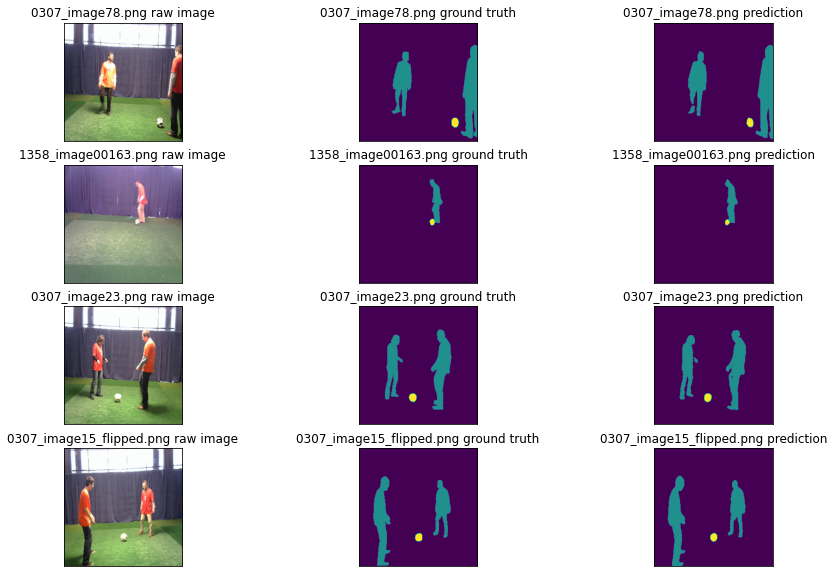

In [18]:
# Display the original, ground truth, and predicted 
# segmentations for four images from the validation data.

display_segmentation_results(s, 
                             model.valid_res_tbl, 
                             n_images=4, 
                             segmentation_labels_table=model.valid_res_tbl,
                             segmentation_prediction_table='final_images_predicted',
                             prediction_column='_image_',
                             filename_column='_filename_0',
                             fig_size=(15,10))